In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout


In [2]:
#path to dataframe containing genes in every gene set
gene_sets_path = '/home/wallet/Downloads/1.3/Cytopus_1.3_gene-sets_x_genes.csv'
#path to dataframe containing metadata about the gene sets
metadata_path = '/home/wallet/Downloads/1.3/Cytopus_1.3_versions_metadata.csv'
#path tto dataframe containing the cell type hierarchy
cellular_hierarchies_path = '/home/wallet/Downloads/1.3/Cytopus_1.3_hierarchies.csv'

# prepare data

## construct cell type hierarchy

We first construct the hierarchy of cell types to which we will then attach the genes sets. For this we need a list of cell types and a list of tuples indicating the all edges between cell types in the format:

celltype_edges = [('celltype_child_1','celltype_parent_1'),('celltype_child_2','celltype_parent_2'),...]

In [3]:
#here we import this information from a dataframe storing the child nodes in column index 0 and parent nodes in column index 1.
cellular_hierarchies= pd.read_csv(cellular_hierarchies_path)
cellular_hierarchies.head()

,child,parent
0,all-cells,leukocyte
1,leukocyte,M
2,leukocyte,TNK
3,TNK,ILC
4,leukocyte,B


In [4]:
 #transform information in dataframe to list of tuples
 celltype_edges = list(zip(list(cellular_hierarchies['child']),list(cellular_hierarchies['parent'])))
 celltype_edges[:10]

[('all-cells', 'leukocyte'),
 ('leukocyte', 'M'),
 ('leukocyte', 'TNK'),
 ('TNK', 'ILC'),
 ('leukocyte', 'B'),
 ('B', 'B-naive'),
 ('all-cells', 'epi'),
 ('epi', 'carcinoma-cell'),
 ('carcinoma-cell', 'NSCLC-carcinoma-cell'),
 ('epi', 'lung-epi')]

## get gene sets and metadata

We first connect genes with their respective gene sets by edges. For this we format the data as it follows:

geneset_gene_edges = [('gene_set_1','gene_1'),('gene_set_2','gene_2'),..]

In [5]:
#here we load the genes belong to each gene set
gene_sets = pd.read_csv(gene_sets_path)
gene_sets.head()


,gene_set_name,gene_name
0,ILC_ILC1_UP,KLRB1
1,ILC_ILC1_UP,IL1R1
2,ILC_ILC1_UP,IL1R2
3,ILC_ILC1_UP,IL12RB1
4,ILC_ILC1_UP,NCR3


In [6]:
#geneset gene edges
geneset_gene_edges = list(zip(list(gene_sets['gene_set_name']),list(gene_sets['gene_name'])))
geneset_gene_edges[:10]

[('ILC_ILC1_UP', 'KLRB1'),
 ('ILC_ILC1_UP', 'IL1R1'),
 ('ILC_ILC1_UP', 'IL1R2'),
 ('ILC_ILC1_UP', 'IL12RB1'),
 ('ILC_ILC1_UP', 'NCR3'),
 ('ILC_ILC1_UP', 'TNFRSF10A'),
 ('ILC_ILC1_UP', 'CXCR3'),
 ('all_DNA-demethylation', 'ADH5'),
 ('all_DNA-demethylation', 'TET1'),
 ('all_DNA-demethylation', 'TET2')]

In [7]:
#here we load the metadata from a data frame, this contains the gene set name, version, cell type, author and information about licensing
metadata = pd.read_csv(metadata_path,index_col='gene_set_name')
metadata.head()

,version_id,cell_type_name,annotation_name,author,license,license_link,license_type,gene_set_type,gene_set_topic
gene_set_name,,,,,,,,,
ILC_ILC1_UP,v_hs69b,ILC1,cellular_identity,wallet,MIT,https://github.com/wallet-maker/cytopus/blob/m...,c,manual_internal,immune_identity
all_DNA-demethylation,v_hs130,all-cells,cellular_process,10.1038/ncomms13041,NaN,NaN,c,manual_external,metabolism
CD4-T_TH9_UP,v_hs70b,CD4-T,cellular_process,wallet,MIT,https://github.com/wallet-maker/cytopus/blob/m...,c,manual_internal,immune_function
all_ros_response,v_hs94,all-cells,cellular_process,Arthur_Liberzon_(MSigDB Team),Creative Commons Attribution 4.0 International...,https://www.gsea-msigdb.org/gsea/msigdb_licens...,c,manual_external,metabolism
all_autophagy-selective,v_hs206,all-cells,cellular_process,GO Term 2019-01-01: 10.5281/zenodo.2529950_210...,Creative Commons Attribution 4.0 Unported Lic...,http://geneontology.org/docs/go-citation-policy/,c,manual_external,cell_death_autophagy


In [8]:
#we format the data identically for the geneset celltype edges
geneset_celltype_edges = list(zip(list(metadata.index),list(metadata['cell_type_name'])))
geneset_celltype_edges[:10]

[('ILC_ILC1_UP', 'ILC1'),
 ('all_DNA-demethylation', 'all-cells'),
 ('CD4-T_TH9_UP', 'CD4-T'),
 ('all_ros_response', 'all-cells'),
 ('all_autophagy-selective', 'all-cells'),
 ('all_fructose-mannose_metabolism', 'all-cells'),
 ('endo_aerocyte_UP', 'endo-aerocyte'),
 ('all_transmembrane-transport-mitochondrial', 'all-cells'),
 ('all_cytosolic-DNA-sensing_signaling', 'all-cells'),
 ('all_type-II-ifn-response', 'all-cells')]

We also need to classify our gene sets into cellular processes (gene programs) or identities (cell type markers)

In [9]:
#provide a dictionary indicating the gene set annotation names
annotation_dict = metadata['annotation_name'].to_dict()
annotation_dict

{'ILC_ILC1_UP': 'cellular_identity',
 'all_DNA-demethylation': 'cellular_process',
 'CD4-T_TH9_UP': 'cellular_process',
 'all_ros_response': 'cellular_process',
 'all_autophagy-selective': 'cellular_process',
 'all_fructose-mannose_metabolism': 'cellular_process',
 'endo_aerocyte_UP': 'cellular_identity',
 'all_transmembrane-transport-mitochondrial': 'cellular_process',
 'all_cytosolic-DNA-sensing_signaling': 'cellular_process',
 'all_type-II-ifn-response': 'cellular_process',
 'all_multidrug-resistance': 'cellular_process',
 'B_effector-2_UP': 'cellular_process',
 'TNK_cytotoxicity-effectors': 'cellular_process',
 'lung-epi_IL17A-IL22_response': 'cellular_process',
 'ILC_lymphoid-tissue-inducer_UP': 'cellular_identity',
 'M_IL4_response': 'cellular_process',
 'DC_antigen-crosspresentation': 'cellular_process',
 'all_TYR_metabolism': 'cellular_process',
 'T_CD8-T_UP': 'cellular_identity',
 'B_plasma-blast_UP': 'cellular_identity',
 'Mac_LPS_response': 'cellular_process',
 'ILC_ILC3-NCR

You can add additional metadata to the gene sets (optional). Provide this data as a nested dictionary of the format:

{'gene_set_1':{'attribute_type_1':'attribute_a',
               'attribute_type_2':'attribute_b',....}...}

In [10]:
metadata_columns = ['version_id', 'author', 'license',
       'license_link', 'license_type', 'gene_set_type', 'gene_set_topic']
metadata_dict = metadata[metadata_columns].to_dict('index')

# construct the KnowledgeBase

In [11]:
#if you want to save the data set save to True and provide the saving location as save_path
import cytopus as cp
G = cp.tl.construct_kb(celltype_edges, geneset_gene_edges,geneset_celltype_edges,annotation_dict,metadata_dict=metadata_dict#,save=True, save_path='~/knowledgebase.txt'
)
G

KnowledgeBase object containing 92 cell types and 222 cellular processes



/home/wallet/miniconda3/envs/2023_cytopus/lib/python3.10/site-packages/pygraphviz/agraph.py:1405: RuntimeWarning: Warning: Could not load "/home/wallet/miniconda3/envs/2023_cytopus/bin/../lib/graphviz/libgvplugin_pango.so.6" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


all celltypes in knowledge base: ['CD8-T_terminal-exhaustion', 'mo-DC', 'endo-aerocyte', 'endo', 'TCM', 'baso', 'colon-epi', 'CD4-TCM', 'Mac', 'gran', 'gdT', 'eosino', 'ILC3-NCRpos', 'FDC', 'CD4-TRM', 'endo-systemic-venous', 'T', 'p-DC', 'CD4-TEM', 'ILC3-NCRneg', 'lung-epi', 'CD8-TCM', 'TSCM', 'ILC2', 'crc-carcinoma-cell', 'endo-lymphatic', 'CD4-Teffector', 'ILC3', 'capillary', 'NK-adaptive', 'B-pb-t3', 'cDC3', 'cDC2', 'mono', 'TFH', 'CD8-T_KLRG1neg-effector', 'NSCLC-carcinoma-cell', 'Treg', 'lung-endo-venous', 'CD8-Teffector', 'M', 'nc-mono', 'CD8-T_KLRG1pos-effector', 'CD4-TSCM', 'mast', 'CD4-T', 'c-mono', 'fibro', 'epi', 'Langerhans', 'CD56bright-NK', 'CD8-TSCM', 'NK', 'carcinoma-cell', 'CD8-TRM', 'B-memory', 'ILC', 'B-pb-t2', 'smooth-muscle', 'ILC1', 'lung-smooth-muscle', 'CD8-T-progenitor-exhausted', 'B-memory-DN', 'B-memory-IgM-MZ', 'TNK', 'Lti', 'B-pb-t1', 'MAIT', 'DC', 'TRM', 'MDC', 'B-memory-switched', 'iNKT', 'plasma-blast', 'B-memory-non-switched', 'B', 'CD56dim-NK', 'CD8-TE

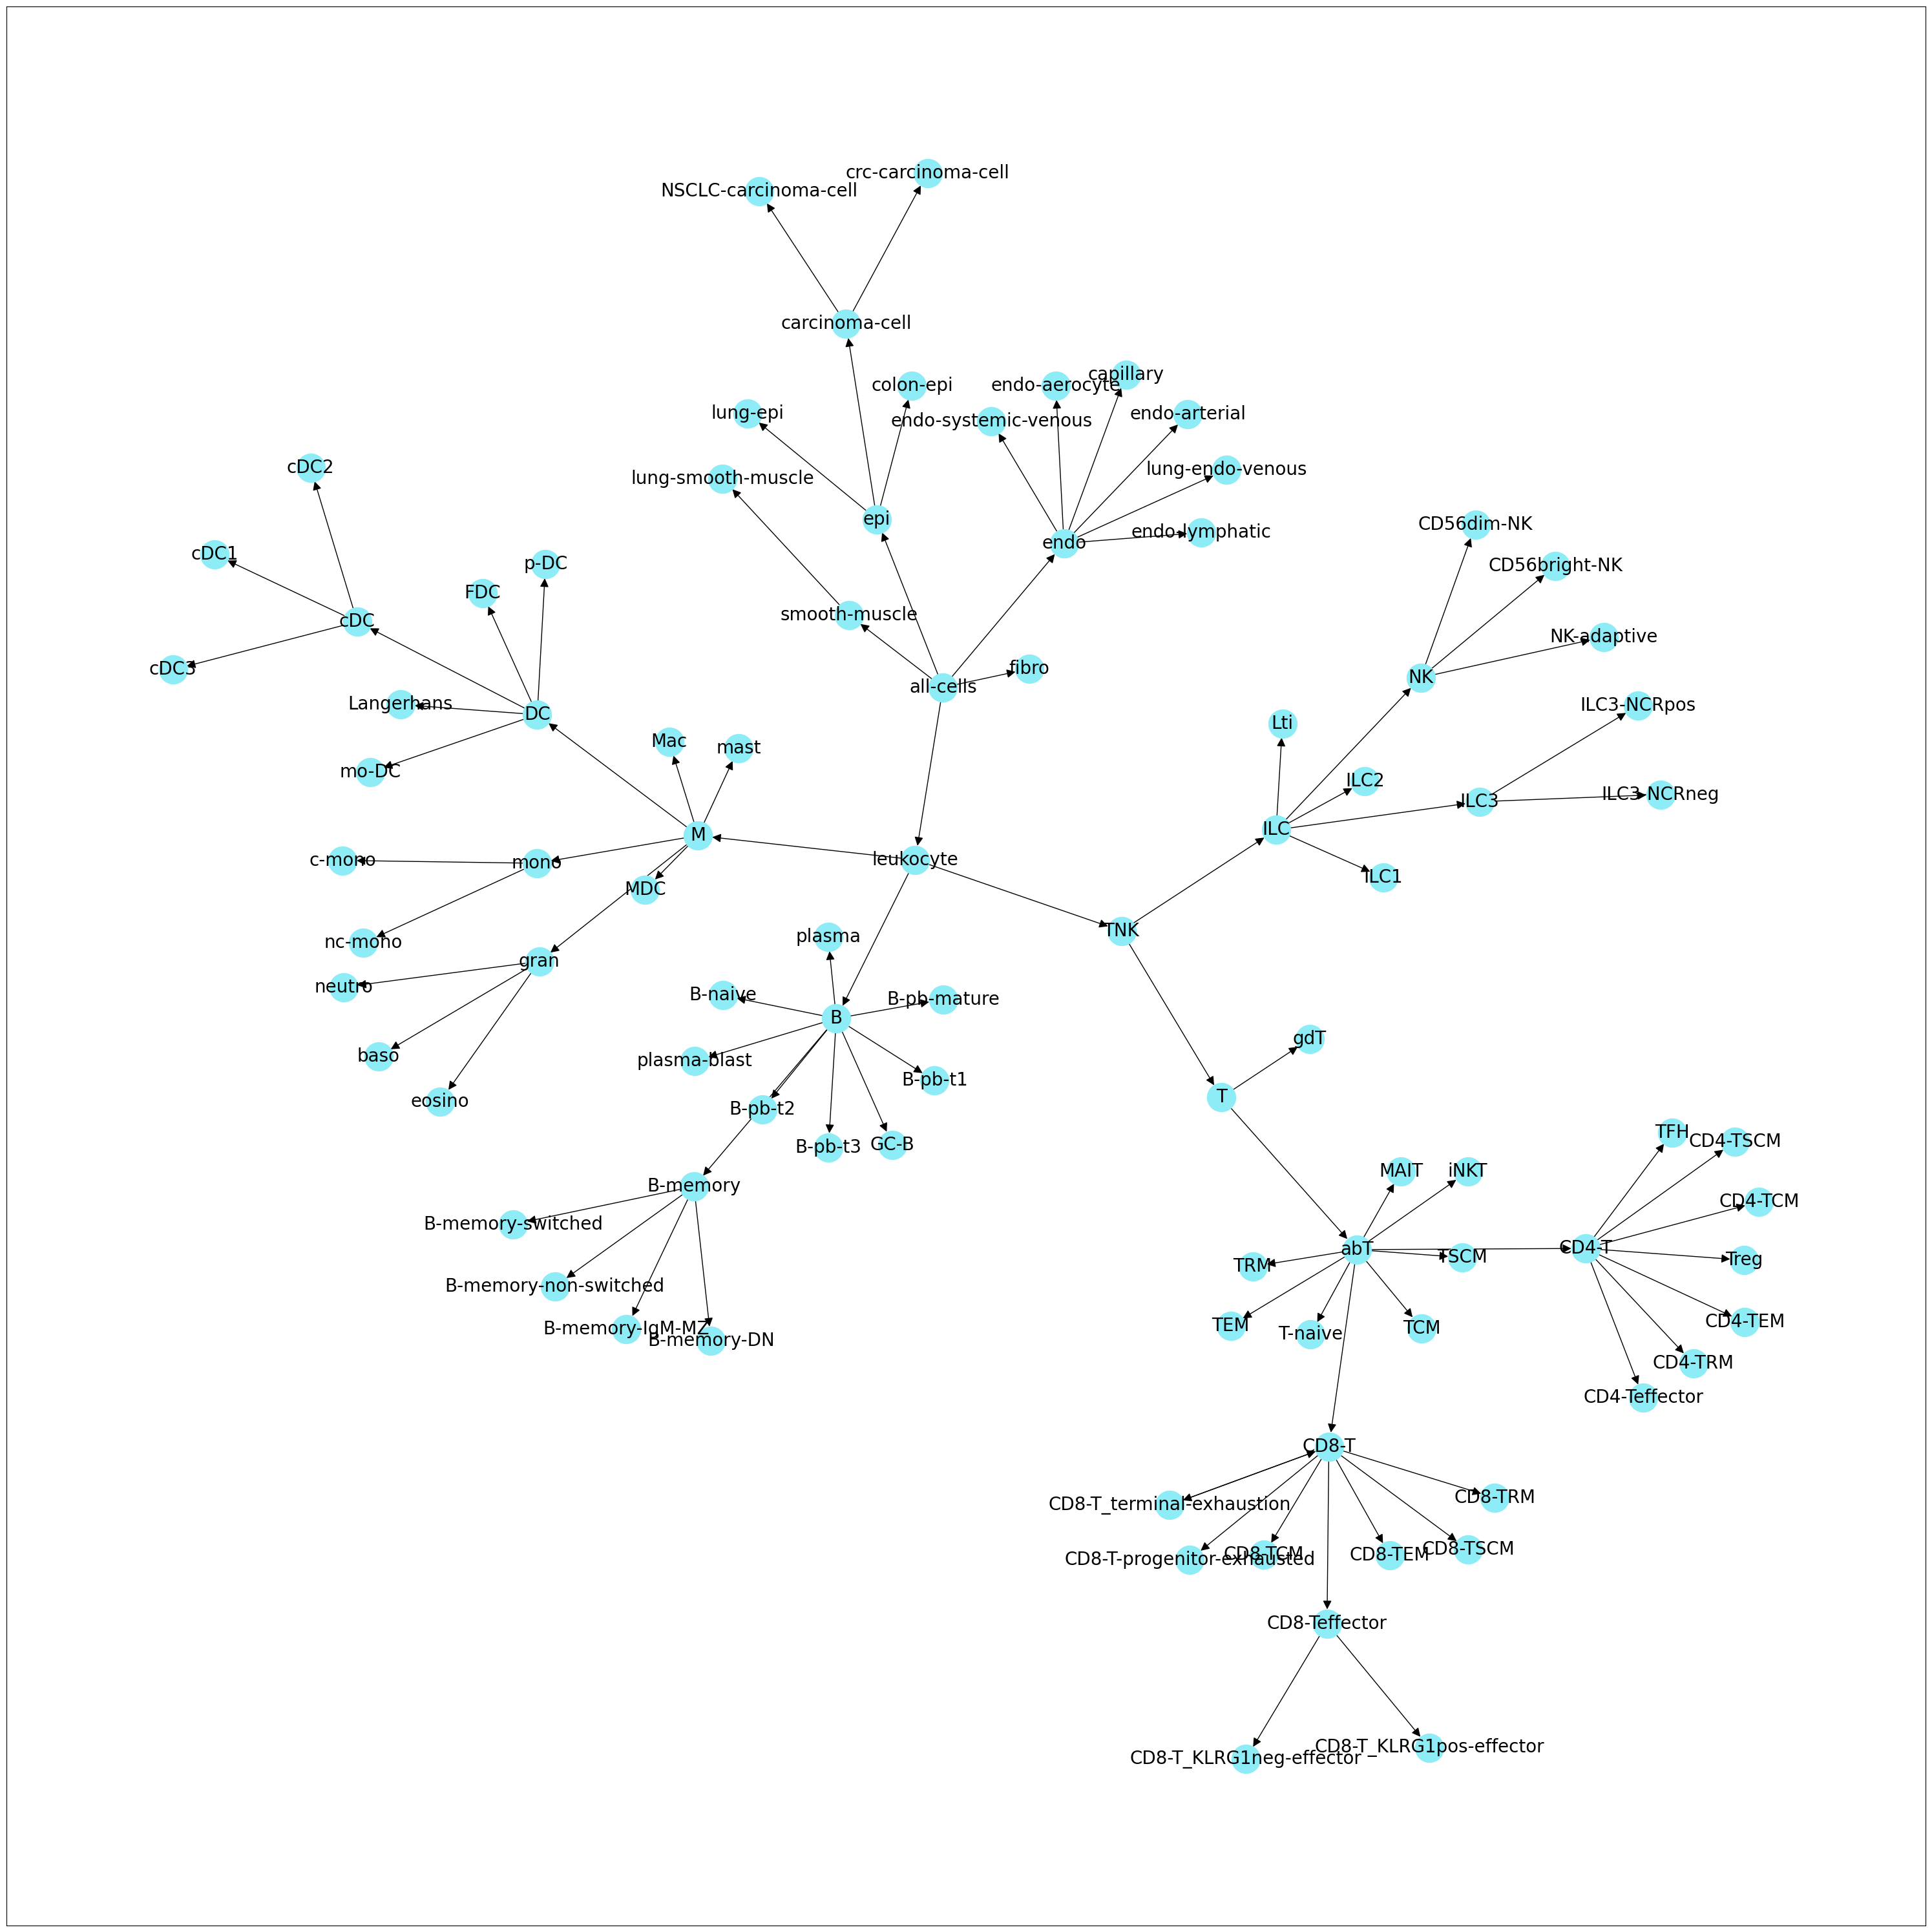

In [12]:
#plot the cell type hierarchy
G.plot_celltypes()